In [1]:
import torch
import torch.optim as optim

# Set the device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transform to normalize and convert to tensor
transform = transforms.Compose([transforms.ToTensor()]) 

# Load MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


import torch.nn as nn
import torch.nn.functional as F

class CVAE(nn.Module):
    def __init__(self, latent_dim, num_classes=10):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        input_dim = 28 * 28 + num_classes  # Include label in input

        # Encoder
        self.fc1 = nn.Linear(input_dim, 400)
        self.fc_mu = nn.Linear(400, latent_dim)
        self.fc_logvar = nn.Linear(400, latent_dim)

        # Decoder
        self.fc2 = nn.Linear(latent_dim + num_classes, 400)
        self.fc3 = nn.Linear(400, 28 * 28)

    def encoder(self, x, y):
        x = torch.cat([x, y], dim=1)
        h = F.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decoder(self, z, y):
        z = torch.cat([z, y], dim=1)
        h = F.relu(self.fc2(z))
        x = torch.sigmoid(self.fc3(h))
        return x

    def forward(self, x, y):
        mu, logvar = self.encoder(x, y)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decoder(z, y)
        return recon_x, mu, logvar


# Prepare one-hot encoded labels
def to_one_hot(labels, num_classes=10):
    batch_size = labels.size(0)
    one_hot = torch.zeros(batch_size, num_classes, device=labels.device)
    one_hot.scatter_(1, labels.view(-1, 1), 1)
    return one_hot

def vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum') 
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div


# Initialize model, optimizer, and device
latent_dim = 30
cvae = CVAE(latent_dim=latent_dim).to(device)
optimizer = optim.Adam(cvae.parameters(), lr=1e-3)

    
epochs=50
# Training loop
for epoch in range(epochs):
    cvae.train()
    train_loss = 0
    for x, labels in train_loader:
        x = x.view(-1, 28 * 28).to(device)  # Flatten the images
        labels = labels.to(device)  # Move labels to the same device as x
        labels_one_hot = to_one_hot(labels, num_classes=10)

        optimizer.zero_grad()
        recon_x, mu, logvar = cvae(x, labels_one_hot)
        loss = vae_loss(recon_x, x, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {train_loss / len(train_loader.dataset):.4f}")

Epoch 1, Loss: 44.1556
Epoch 2, Loss: 32.9589
Epoch 3, Loss: 30.6584
Epoch 4, Loss: 29.3926
Epoch 5, Loss: 28.5430
Epoch 6, Loss: 27.9790
Epoch 7, Loss: 27.5822
Epoch 8, Loss: 27.2463
Epoch 9, Loss: 27.0406
Epoch 10, Loss: 26.8017
Epoch 11, Loss: 26.6279
Epoch 12, Loss: 26.4740
Epoch 13, Loss: 26.3201
Epoch 14, Loss: 26.2324
Epoch 15, Loss: 26.1083
Epoch 16, Loss: 26.0063
Epoch 17, Loss: 25.8789
Epoch 18, Loss: 25.8193
Epoch 19, Loss: 25.7118
Epoch 20, Loss: 25.6532
Epoch 21, Loss: 25.6090
Epoch 22, Loss: 25.5246
Epoch 23, Loss: 25.4583
Epoch 24, Loss: 25.4017
Epoch 25, Loss: 25.3536
Epoch 26, Loss: 25.3192
Epoch 27, Loss: 25.2493
Epoch 28, Loss: 25.2195
Epoch 29, Loss: 25.1720
Epoch 30, Loss: 25.1147
Epoch 31, Loss: 25.0815
Epoch 32, Loss: 25.0578
Epoch 33, Loss: 25.0153
Epoch 34, Loss: 24.9613
Epoch 35, Loss: 24.9511
Epoch 36, Loss: 24.9019
Epoch 37, Loss: 24.8734
Epoch 38, Loss: 24.8590
Epoch 39, Loss: 24.8046
Epoch 40, Loss: 24.8046
Epoch 41, Loss: 24.7688
Epoch 42, Loss: 24.7309
E

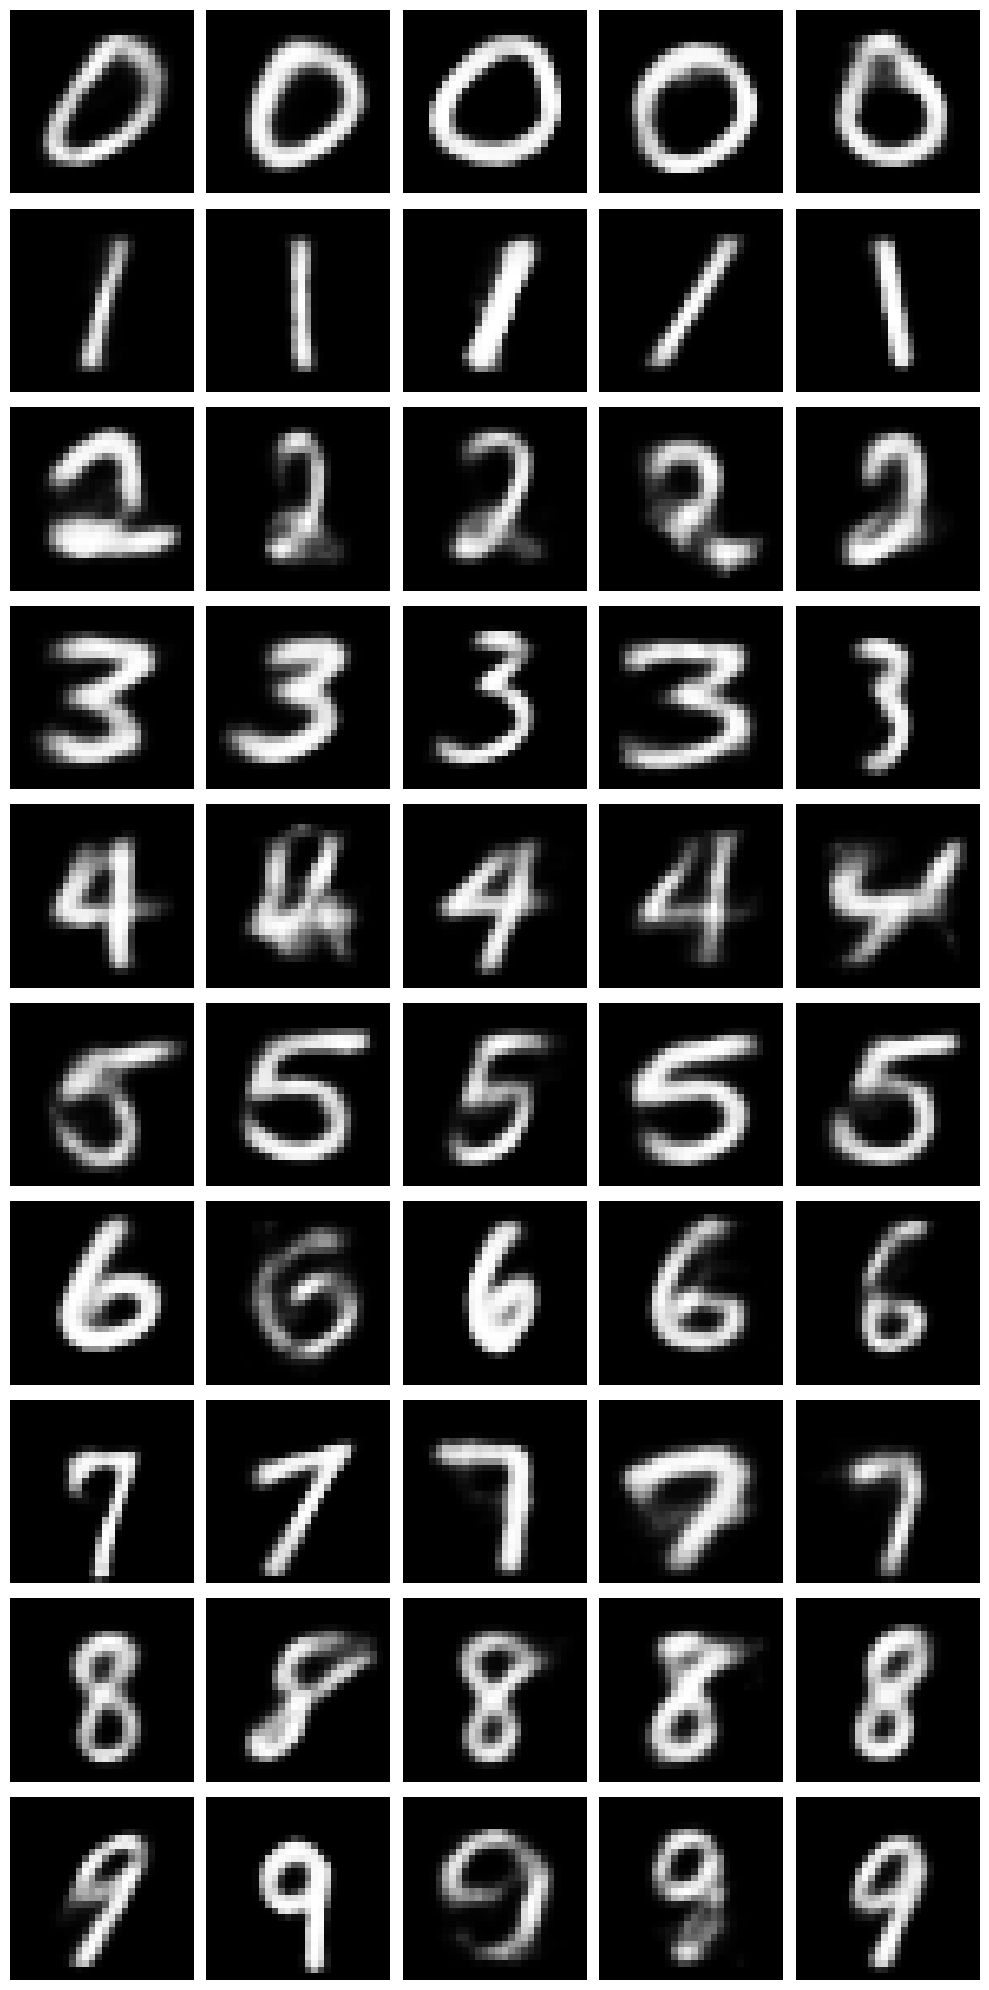

In [2]:
import matplotlib.pyplot as plt

# Visualize the generated images
def generate_samples(cvae, class_label, num_samples=5, latent_dim=30):
    cvae.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(device)  # Random latent vectors
        labels = torch.tensor([class_label] * num_samples, device=device)
        labels_one_hot = to_one_hot(labels, num_classes=10)
        generated = cvae.decoder(z, labels_one_hot).view(-1, 1, 28, 28).cpu()
    return generated

# Generate images for all classes (0 to 9)
generated_images_all_classes = []
for class_label in range(10):  # Loop over class labels 0 to 9
    generated_images = generate_samples(cvae, class_label=class_label, num_samples=5)
    generated_images_all_classes.append(generated_images)

# Flatten the list into a single list of images for easy visualization
generated_images_flat = [img for sublist in generated_images_all_classes for img in sublist]

def visualize_generated_images(images, num_cols=5):
    num_images = len(images)
    num_rows = (num_images + num_cols - 1) // num_cols  # Calculate rows needed
    
    plt.figure(figsize=(num_cols * 2, num_rows * 2))
    
    for i, img in enumerate(images):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(img.squeeze(), cmap='gray')  # Squeeze to remove channel dimension
        plt.axis('off')  # Remove axes for better visualization
    
    plt.tight_layout()
    plt.show()

# Visualize the generated images (50 images total, ordered by class)
visualize_generated_images(generated_images_flat)

In [3]:
def interpolate_latents(cvae, class_label_1, class_label_2, num_samples=5, latent_dim=30):
    cvae.eval()
    with torch.no_grad():
        # Generate two random latent vectors
        z_1 = torch.randn(1, latent_dim).to(device)
        z_2 = torch.randn(1, latent_dim).to(device)

        # Create one-hot labels for the two classes
        label_1 = torch.tensor([class_label_1], device=device)
        label_2 = torch.tensor([class_label_2], device=device)
        one_hot_1 = to_one_hot(label_1, num_classes=10)
        one_hot_2 = to_one_hot(label_2, num_classes=10)

        # Interpolate between z_1 and z_2
        interpolated_latents = [
            z_1 + (z_2 - z_1) * (i / (num_samples - 1)) for i in range(num_samples)
        ]

        # Decode each interpolated latent
        generated_images = []
        for z in interpolated_latents:
            # Use labels for class 1 and class 2 as the conditioning input
            one_hot_label = one_hot_1 if torch.allclose(z, z_1) else one_hot_2
            generated_image = cvae.decoder(z, one_hot_label).view(28, 28).cpu().numpy()
            generated_images.append(generated_image)

    return generated_images

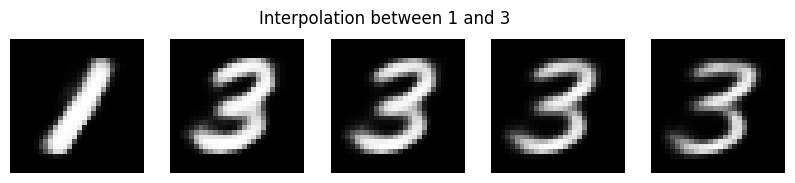

In [4]:
# Visualize the interpolated images
def visualize_interpolation(images, class_label_1, class_label_2, num_cols=5):
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=(num_cols * 2, 2))
    fig.suptitle(f"Interpolation between {class_label_1} and {class_label_2}")

    # Ensure axes is always iterable, even for a single image
    if num_images == 1:
        axes = [axes]

    for i, (img, ax) in enumerate(zip(images, axes)):
        ax.imshow(img, cmap='gray')
        ax.axis('off')  # Completely turn off the axis for each subplot

    # plt.tight_layout()
    plt.show()
    
# Interpolate between class 1 and class 3
interpolated_images = interpolate_latents(cvae, class_label_1=1, class_label_2=3, num_samples=5)
visualize_interpolation(interpolated_images, class_label_1=1, class_label_2=3)

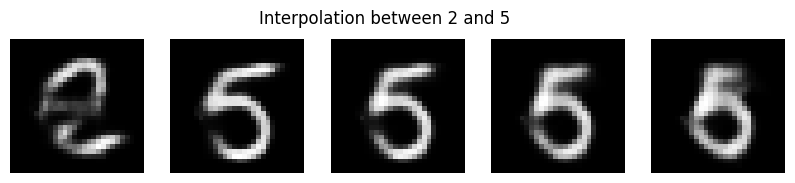

In [5]:
# Interpolate between class 2 and class 5
interpolated_images = interpolate_latents(cvae, class_label_1=2, class_label_2=5, num_samples=5)
visualize_interpolation(interpolated_images, class_label_1=2, class_label_2=5)

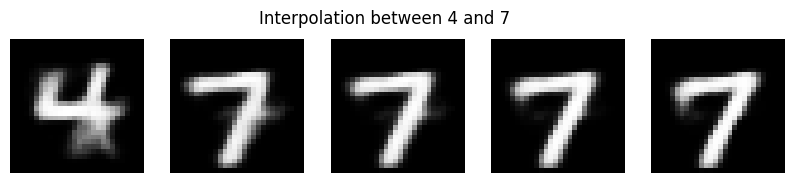

In [6]:
# Interpolate between class 4 and class 7
interpolated_images = interpolate_latents(cvae, class_label_1=4, class_label_2=7, num_samples=5)
visualize_interpolation(interpolated_images, class_label_1=4, class_label_2=7)

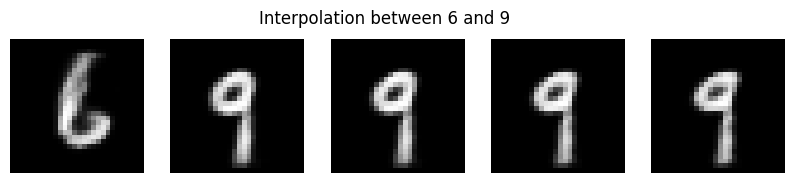

In [7]:
# Interpolate between class 6 and class 9
interpolated_images = interpolate_latents(cvae, class_label_1=6, class_label_2=9, num_samples=5)
visualize_interpolation(interpolated_images, class_label_1=6, class_label_2=9)